In [1]:
!pip install nltk
!pip install seaborn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
df = pd.read_csv("all_tickets_processed_improved_v3.csv")
df.head()


,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [5]:
df.info()
df['Topic_group'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47837 entries, 0 to 47836
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Document     47837 non-null  object
 1   Topic_group  47837 non-null  object
dtypes: object(2)
memory usage: 747.6+ KB


,count
Topic_group,
Hardware,13617
HR Support,10915
Access,7125
Miscellaneous,7060
Storage,2777
Purchase,2464
Internal Project,2119
Administrative rights,1760


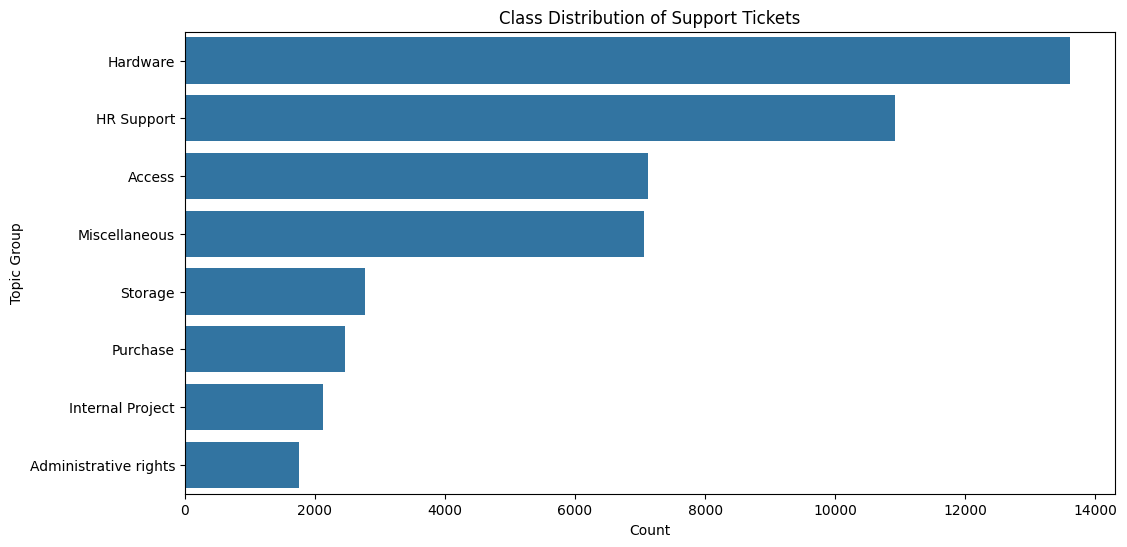

In [8]:


plt.figure(figsize=(12,6))
sns.countplot(y=df['Topic_group'], order=df['Topic_group'].value_counts().index)
plt.title("Class Distribution of Support Tickets")
plt.xlabel("Count")
plt.ylabel("Topic Group")
plt.show()


In [9]:


nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

df['clean_text'] = df['Document'].apply(clean_text)

df[['Document','clean_text']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Document,clean_text
0,connection with icon icon dear please setup ic...,connection icon icon dear please setup icon pe...
1,work experience user work experience user hi w...,work experience user work experience user hi w...
2,requesting for meeting requesting meeting hi p...,requesting meeting requesting meeting hi pleas...
3,reset passwords for external accounts re expir...,reset password external account expire day hi ...
4,mail verification warning hi has got attached ...,mail verification warning hi got attached plea...


In [10]:
vectorizer = TfidfVectorizer(
    max_features=6000,
    ngram_range=(1,2),
    min_df=3
)

X = vectorizer.fit_transform(df['clean_text'])
y = df['Topic_group']

print("Feature shape:", X.shape)

Feature shape: (47837, 6000)


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 38269
Testing samples: 9568


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_model = LogisticRegression(max_iter=1000)

log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.8548285953177257

Classification Report:

                       precision    recall  f1-score   support

               Access       0.91      0.88      0.89      1425
Administrative rights       0.88      0.62      0.73       352
           HR Support       0.86      0.87      0.87      2183
             Hardware       0.80      0.89      0.84      2724
     Internal Project       0.92      0.82      0.86       424
        Miscellaneous       0.83      0.82      0.82      1412
             Purchase       0.97      0.87      0.92       493
              Storage       0.93      0.82      0.87       555

             accuracy                           0.85      9568
            macro avg       0.89      0.82      0.85      9568
         weighted avg       0.86      0.85      0.85      9568



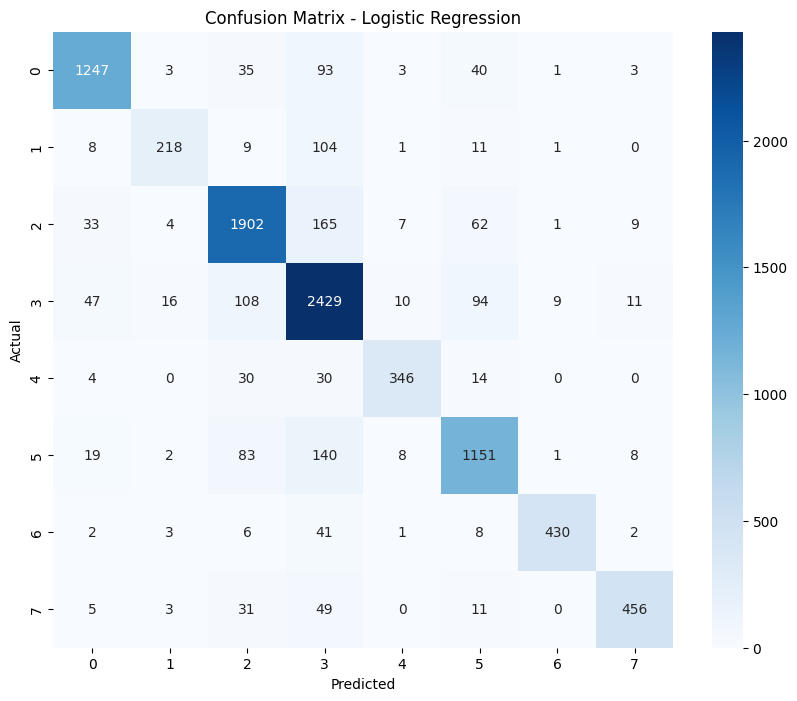

In [15]:



cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [14]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(log_model, X, y, cv=5)

print("Cross Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


Cross Validation Scores: [0.84845318 0.8180393  0.80244591 0.80976273 0.74986934]
Mean CV Accuracy: 0.8057140902587037


In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))


Random Forest Accuracy: 0.8473035117056856


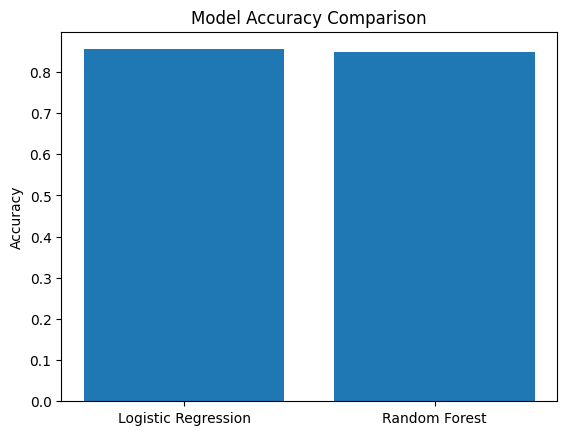

In [17]:
models = ['Logistic Regression', 'Random Forest']
accuracies = [
    accuracy_score(y_test, y_pred),
    accuracy_score(y_test, rf_pred)
]

plt.figure()
plt.bar(models, accuracies)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()


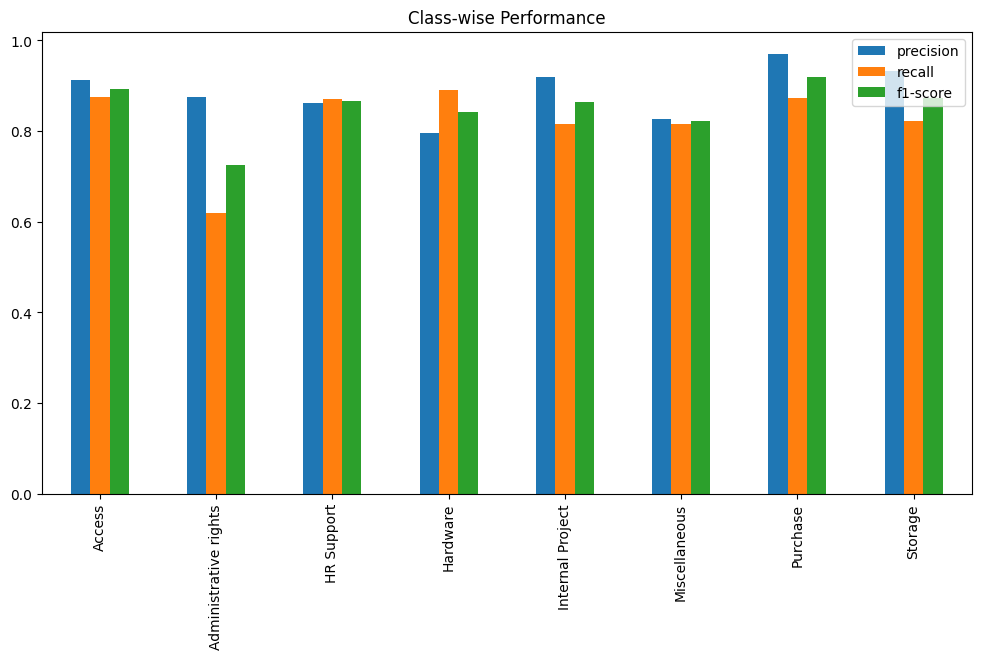

In [18]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.iloc[:-3][['precision','recall','f1-score']].plot(kind='bar', figsize=(12,6))
plt.title("Class-wise Performance")
plt.show()

In [19]:
from google.colab import drive
drive.mount('/content/drive')

MODEL_PATH = "/content/drive/MyDrive/ticket_classifier_model.pkl"
VECTORIZER_PATH = "/content/drive/MyDrive/tfidf_vectorizer.pkl"


Mounted at /content/drive


In [21]:
import joblib

joblib.dump(log_model, MODEL_PATH)
joblib.dump(vectorizer, VECTORIZER_PATH)

print("Model saved to Drive successfully.")


Model saved to Drive successfully.


In [22]:
loaded_model = joblib.load(MODEL_PATH)
loaded_vectorizer = joblib.load(VECTORIZER_PATH)

sample_ticket = ["my laptop is not connecting to wifi"]
sample_clean = [clean_text(sample_ticket[0])]
sample_vector = loaded_vectorizer.transform(sample_clean)

prediction = loaded_model.predict(sample_vector)

print("Predicted Category:", prediction[0])


Predicted Category: Hardware


In [24]:
df['Topic_group'].unique()


array(['Hardware', 'Access', 'Miscellaneous', 'HR Support', 'Purchase',
       'Administrative rights', 'Storage', 'Internal Project'],
      dtype=object)